In [29]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import pylab as pl
import seaborn as sns

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [2]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'MSFT', 'GOOG']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2016, 12, 31)

dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']

dataset.head()

,Open,High,Low,Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2016-01-06,100.56,102.37,99.87,100.70,-0.019570,103.892,108.130311,99.653689,-0.044139,96.45
2016-01-07,98.68,100.13,96.43,96.45,-0.042205,102.112,109.553699,94.670301,-0.084480,96.96
2016-01-08,98.55,99.11,96.76,96.96,0.005288,100.434,108.007567,92.860433,-0.079639,96.96
2016-01-09,98.55,99.11,96.76,96.96,0.000000,98.756,104.340095,93.171905,-0.079639,96.96
2016-01-10,98.55,99.11,96.76,96.96,0.000000,97.606,101.093280,94.118720,-0.055983,98.53


## Find hyperparameters for model

In [5]:
def cross_val_splits(X, n_splits=5):
    splits = TimeSeriesSplit(n_splits)
    cv_splits = []

    for train_index, test_index in splits.split(X):
        cv_splits.append((train_index, test_index))

    return cv_splits

In [4]:
lasso = Lasso(random_state=rs)
lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

ridge = Ridge(random_state=rs)
ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

elasticnet = ElasticNet(random_state=rs)
elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

lin_reg = LinearRegression()

models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

scores = []
estimators = []

for model, params in models_params:
    class_name = model.__class__.__name__
    
    print ("\n{0}: \n".format(class_name))

    steps = [('scaler', StandardScaler()), ('reg', model)]
    pipe = Pipeline(steps)

    cv_splits = cross_val_splits(data, n_splits = 5)
    grid_search = GridSearchCV(pipe, params, cv = cv_splits)

    grid_search.fit(data, target)

    best_params = grid_search.best_params_
    print('best parameters: {0}'.format(best_params))

    best_score = grid_search.best_score_
    print('best score: {0}'.format(best_score))
    
    scores.append(best_score)

    best_estimator = grid_search.best_estimator_
    estimators.append(best_estimator)


Lasso: 



/Users/ciprian/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'reg__max_iter': 10000, 'reg__alpha': 1e-05}
best score: 0.870653572838

Ridge: 

best parameters: {'reg__alpha': 0.0001}
best score: 0.870653691351

ElasticNet: 

best parameters: {'reg__l1_ratio': 0.1, 'reg__alpha': 0.001}
best score: 0.870715750694

LinearRegression: 

best parameters: {}
best score: 0.870653829683


## Generate training and testing datasets

In [5]:
data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

print ('Training set has {0} samples.'.format(X_train.shape[0]))
print ('Testing set has {0} samples.'.format(X_test.shape[0]))

Training set has 252 samples.
Testing set has 108 samples.


In [6]:
def plot_predictions(title, y, y_hat):
    pl.title(title)
    pl.plot(y, y_hat, 'ro')
    pl.plot([np.amin(y), np.amax(y)],[np.amin(y_hat), np.amax(y_hat)], 'g-')
    pl.xlabel('Real values')
    pl.ylabel('Predicted values')
    pl.show()

In [9]:
def print_cross_val_accuracy(est, X, y):
    scores = cross_val_score(est, X, y)
    print('cross validation accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


Lasso: 

score for training set: 0.973930288765
cross validation accuracy: 0.97 (+/- 0.01)
score for test set: 0.978015156164
cross validation accuracy: 0.98 (+/- 0.01)


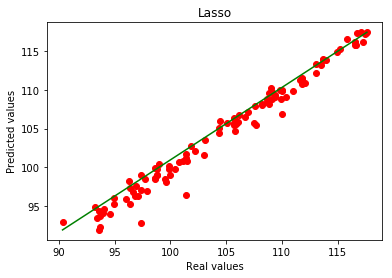


Ridge: 

score for training set: 0.973930290774
cross validation accuracy: 0.97 (+/- 0.01)
score for test set: 0.978009503534
cross validation accuracy: 0.98 (+/- 0.01)


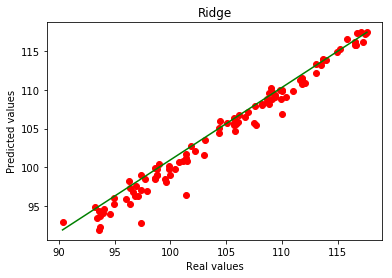


ElasticNet: 

score for training set: 0.973836403969
cross validation accuracy: 0.97 (+/- 0.01)
score for test set: 0.979156826147
cross validation accuracy: 0.98 (+/- 0.01)


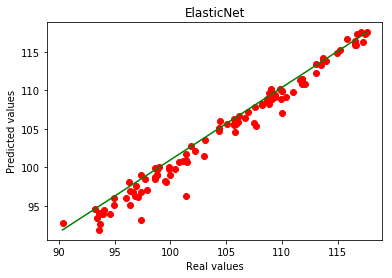


LinearRegression: 

score for training set: 0.973930290812
cross validation accuracy: 0.97 (+/- 0.01)
score for test set: 0.978008637172
cross validation accuracy: 0.98 (+/- 0.01)


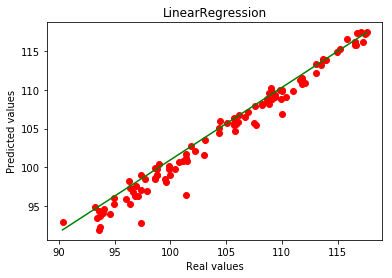

In [10]:
for reg in estimators:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    reg.fit(X_train, y_train)
    
    print('score for training set: {0}'.format(reg.score(X_train, y_train)))
    
    print_cross_val_accuracy(reg, X_train, y_train)

    y_hat_test = reg.predict(X_test)
    print('score for test set: {0}'.format(reg.score(X_test, y_test)))
    
    print_cross_val_accuracy(reg, X_test, y_test)
    
    plot_predictions(class_name, y_test, y_hat_test)

## Generate a validation set and test the prediction accuracy

In [11]:
symbol = tickers[0]
window = 5
look_ahead = 1
valid_start_date = datetime.datetime(2017, 1, 1)
valid_end_date = datetime.datetime(2017, 1, 31)

valid_dataset = su.preprocess_data(symbol, window, look_ahead, valid_start_date, valid_end_date)

valid_dataset.head()

,Open,High,Low,Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2017-01-06,116.78,118.16,116.47,117.91,0.011148,116.568,118.134040,115.001960,0.015153,117.91
2017-01-07,116.78,118.16,116.47,117.91,0.000000,116.920,118.779892,115.060108,0.015153,117.91
2017-01-08,116.78,118.16,116.47,117.91,0.000000,117.272,119.068352,115.475648,0.015153,118.99
2017-01-09,117.95,119.43,117.94,118.99,0.009160,117.866,119.553223,116.178777,0.025599,119.11
2017-01-10,118.77,119.38,118.30,119.11,0.001008,118.366,119.617687,117.114313,0.021439,119.75



Lasso: 

score for validation set: 0.749143716021


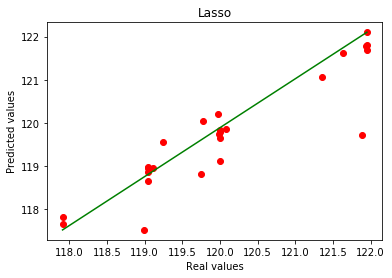


Ridge: 

score for validation set: 0.749168424235


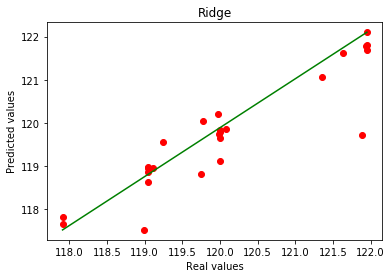


ElasticNet: 

score for validation set: 0.747042967446


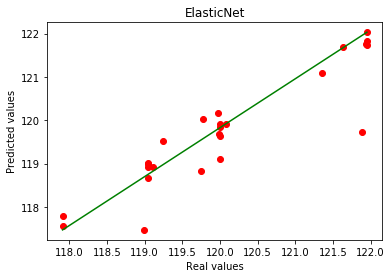


LinearRegression: 

score for validation set: 0.74917050917


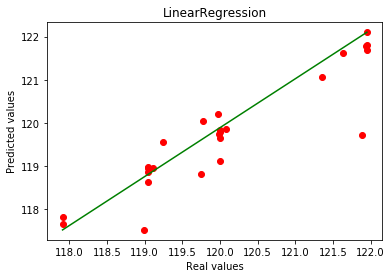


r2 score for average predictions: 0.748915096839

mean squared error for average predictions: 0.381693243748


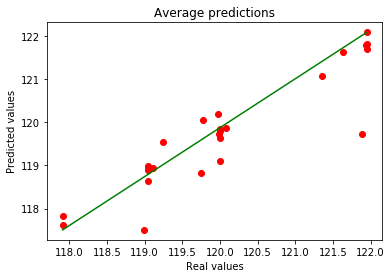

In [14]:
validation_data = valid_dataset.drop(labels=['Future Price'], axis=1)
validation_target = valid_dataset['Future Price']

predictions = []

for reg in estimators:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    validation_pred = reg.predict(validation_data)
    
    score = reg.score(validation_data, validation_target)
    print('score for validation set: {0}'.format(score))
    
    predictions.append(validation_pred)
    plot_predictions(class_name, validation_target, validation_pred)
        
average_predictions = np.zeros(validation_target.shape[0])

for p in predictions:
    average_predictions += p

average_predictions /= len(predictions)
    
print('\nr2 score for average predictions: {0}'.format(r2_score(validation_target, average_predictions)))
print('\nmean squared error for average predictions: {0}'.format(mean_squared_error(validation_target, average_predictions)))

plot_predictions('Average predictions', validation_target, average_predictions)


In [15]:
def up_or_down(x):
    diff = np.roll(x, -1) - x
    ud = [1 if v > 0 else 0 for v in diff]
    return np.array(ud[:-1])

ud_real = up_or_down(validation_target.values)
ud_predicted = up_or_down(average_predictions)

t = np.vstack((ud_real, ud_predicted))
total_predictions = ud_real.shape[0]
correct_predictions = len(np.where(t[0] == t[1])[0])

print('Correct prediction percentage: {0:.2f}'.format((float(correct_predictions) / total_predictions) * 100))

Correct prediction percentage: 50.00


## Identify the market trends using unsupervised learning

In [90]:
rs = 42 # random state
symbol = 'SPY'
window = 5
look_ahead = 1
start_date = datetime.datetime(2016, 9, 16)
end_date = datetime.datetime(2017, 7, 31)

all_dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

dataset = all_dataset.drop(labels=['Future Price', 'Daily return', 'Rolling mean {0}'.format(window), \
                            'Lower Bollinger band {0}'.format(window),\
                           'Upper Bollinger band {0}'.format(window),\
                           'Cummulative return {0}'.format(window)], axis=1)
target = all_dataset['Future Price']

dataset.head()

,Open,High,Low,Close
2016-09-21,214.24,216.03,213.44,215.82
2016-09-22,217.00,217.53,216.71,217.18
2016-09-23,216.72,216.88,215.88,215.99
2016-09-24,216.72,216.88,215.88,215.99
2016-09-25,216.72,216.88,215.88,215.99


In [91]:
mix = GaussianMixture(random_state=rs)
mix_params = {'n_components' : [2, 3, 4, 5, 6], \
              'covariance_type' : ['full', 'tied', 'diag', 'spherical'], \
              'max_iter' : [100, 1000, 10000]
             }

cv_splits = cross_val_splits(dataset, n_splits = 5)

grid_search = GridSearchCV(mix, mix_params, cv = cv_splits)

grid_search.fit(dataset, target)

best_params = grid_search.best_params_
print('best parameters: {0}'.format(best_params))

regimes_number = best_params['n_components']
print('Number of regimes identified: {0}'.format(regimes_number))

best_mix = grid_search.best_estimator_

best parameters: {'max_iter': 100, 'covariance_type': 'full', 'n_components': 2}
Number of regimes identified: 2


In [92]:
best_mix.fit(data)
regime = best_mix.predict(data)

regimes = pd.DataFrame(regime, columns = ['Regime'], index = dataset.index)
dataset = dataset.join(target)
dataset['Return'] = np.log(dataset['Future Price'] / dataset['Close'])

regimes = regimes.join(dataset)
regimes = regimes.assign(market_cu_return=regimes.Return.cumsum())
regimes['Date'] = regimes.index
regimes.head()

,Regime,Open,High,Low,Close,Future Price,Return,market_cu_return,Date
2016-09-21,0,214.24,216.03,213.44,215.82,217.18,0.006282,0.006282,2016-09-21
2016-09-22,0,217.00,217.53,216.71,217.18,215.99,-0.005494,0.000787,2016-09-22
2016-09-23,0,216.72,216.88,215.88,215.99,215.99,0.000000,0.000787,2016-09-23
2016-09-24,0,216.72,216.88,215.88,215.99,215.99,0.000000,0.000787,2016-09-24
2016-09-25,0,216.72,216.88,215.88,215.99,214.24,-0.008135,-0.007348,2016-09-25


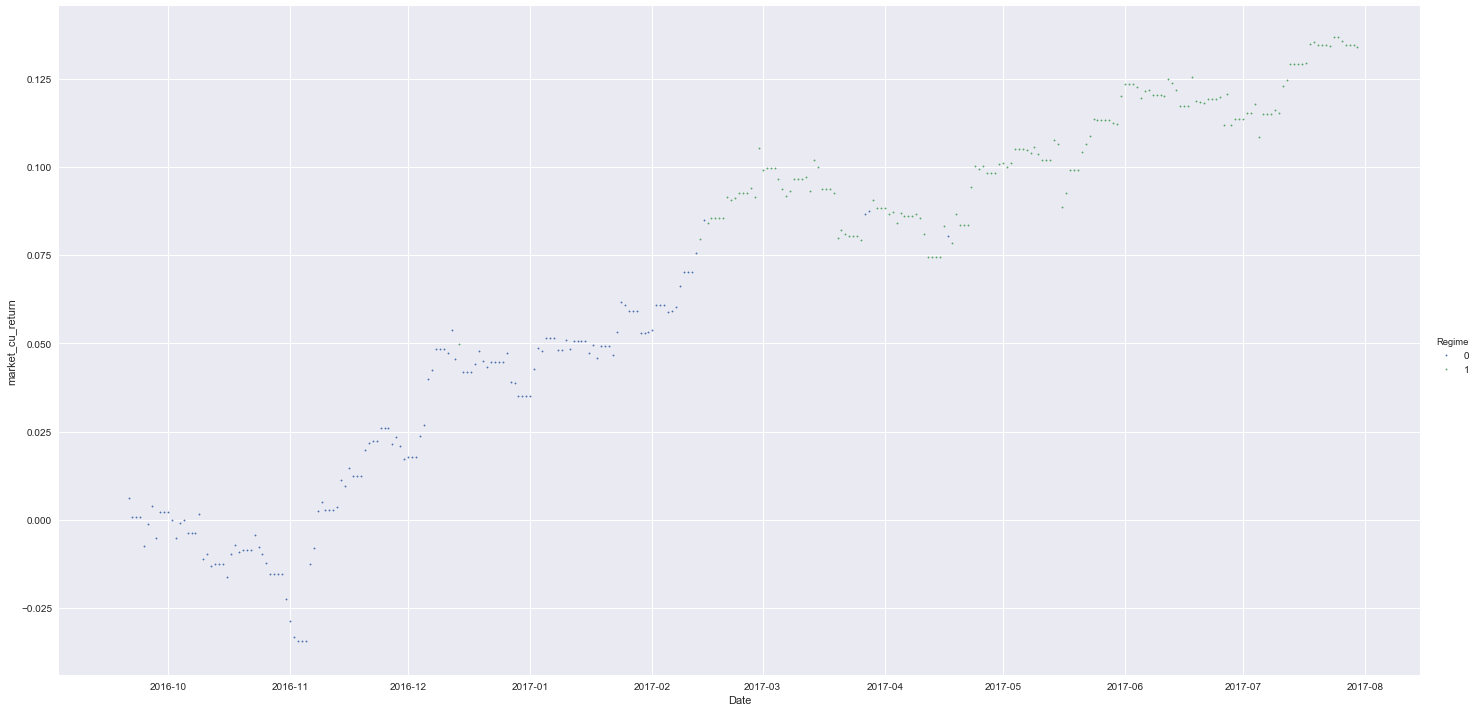

In [93]:
order = np.arange(0, regimes_number)
fig = sns.FacetGrid(data=regimes, hue='Regime', hue_order=order, aspect=2, size=10)
fig.map(plt.pyplot.scatter, 'Date', 'market_cu_return', s=2).add_legend()
plt.pyplot.show()

In [94]:
for i in order:
    print('Mean for regime {0}: {1}'.format(i, best_mix.means_[i][0]))
    print('Co-variance for regime {0}: {1}'.format(i, best_mix.covariances_[i]))
    

Mean for regime 0: 221.522505256
Co-variance for regime 0: [[ 44.13818055  43.728261    45.0242817   44.94130695]
 [ 43.728261    43.68458795  44.78969186  44.98330546]
 [ 45.0242817   44.78969186  46.30902458  46.25558006]
 [ 44.94130695  44.98330546  46.25558006  46.54101097]]
Mean for regime 1: 239.370553697
Co-variance for regime 1: [[ 18.34595279  17.80618725  18.39983366  18.38201934]
 [ 17.80618725  17.50170062  17.99967301  18.09281578]
 [ 18.39983366  17.99967301  18.87439631  18.84696198]
 [ 18.38201934  18.09281578  18.84696198  19.06107417]]
